# ***Proyecto Individual 02 - Datathon - Hospitalización***
---

## Objetivo
El objetivo del proyecto es lograr predecir con de manera fiable si la estadía de un paciente que ingresa a hospitalización va a ser corta o larga. Para ello se aplican los pasos y técnicas necesarias de Machine Learning para llegar al resultado final.

## Estructura del proyecto
Para estructurar el trabajo me inspiro en la [Guía CRISP-DM de IBM](https://www.ibm.com/docs/es/SS3RA7_18.4.0/pdf/ModelerCRISPDM.pdf). Algunos pasos a seguir son:

* 1) Entendimiento del Problema y comprensión de los datos
* 2) Preparación de los datos
* 3) Modelado
* 4) Evaluación y validación

## Instalación e importación de librerias y paquetes necesarios

In [4]:
#Instalación de paquetes y librerías necesarias
#!pip uninstall -y pandas-profiling
#!pip install pandas_profiling #--upgrade
#!pip install dython
#!pip install matplotlib --upgrade

In [67]:
# Trabajo con datos
import numpy as np
import pandas as pd
# opciones de visualización de pandas
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format

# Análisis exploratorio de datos
from pandas_profiling import ProfileReport
from dython.nominal import associations
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

# Preprocesamiento de Datos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer

# Pipelines y Column transformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Modelado
from time import perf_counter #Time para evaluar tiempos de procesado de modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Evaluacion y Validadción - Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Optimización de hiperparámetros

# Manejo de Warnings
import warnings
warnings.filterwarnings("ignore")

## **1) Entendimiento del problema y comprensión de los datos**

El estancia u ocupación hospitalaria es un tema de importancia a nivel mundial debido a que cuando se torna prolongada puede constituir un problema con efectos negativos en el sistema de salud, generando deficiencias en la prestación del servicio.
Se disponibilizan datos históricos de ingresos de pacientes a un Centro de Salud importante, y se conseguir un modelo que permita clasificar un nuevo paciente si va a tener una estadía corta o prolongada.  
**Se considera hospitalización corta con una duración menor o igual a 8 días**

### Dataset
---

El dataset contiene 410.000 registros y 15 dimensiones, el cual incluye la información _numérica_ de la cantidad de días

> **Descripción de las variables**
- Available Extra Rooms in Hospital: Habitaciones adicionales disponibles en el hospital. Una habitación no es igual a un paciente, pueden ser individuales o compartidas.
- Department: Área de atención a la que ingresa el paciente. 
- Ward_Facility_Code: Código de la habitación del paciente.
- doctor_name: Nombre de el/la doctor/a a cargo del paciente.
- staff_available: Cantidad de personal disponible al momento del ingreso del paciente.
- patientid: Identificador del paciente.
- Age: Edad del paciente.
- gender: Género del paciente.
- Type of Admission: Tipo de ingreso registrado según la situación de ingreso del paciente.
- Severity of Illness: Gravedad de la enfermedad/condición/estado del paciente al momento del ingreso.
- health_conditions: Condiciones de salud del paciente. 
- Visitors with Patient: Cantidad de visitantes registrados para el paciente.
- Insurance: Indica si la persona posee o no seguro de salud. 
- Admission_Deposit: Pago realizado a nombre del paciente, con el fin de cubrir los costos iniciales de internación. 
- Stay (in days): Días registrados de estancia hospitalaria. 

In [6]:
df_raw = pd.read_csv('./Data/hospitalizaciones_train.csv')

In [7]:
df_raw.head()

Available Extra Rooms in Hospital  Department Ward_Facility_Code  \
0                                  4  gynecology                  D   
1                                  4  gynecology                  B   
2                                  2  gynecology                  B   
3                                  4  gynecology                  D   
4                                  2  anesthesia                  E   

  doctor_name  staff_available  patientid    Age  gender Type of Admission  \
0   Dr Sophia                0      33070  41-50  Female            Trauma   
1   Dr Sophia                2      34808  31-40  Female            Trauma   
2   Dr Sophia                8      44577  21-30  Female            Trauma   
3   Dr Olivia                7       3695  31-40  Female            Urgent   
4     Dr Mark               10     108956  71-80    Male            Trauma   

  Severity of Illness health_conditions  Visitors with Patient Insurance  \
0             Extreme          Diabetes                      4       Yes   
1               Minor     Heart disease                      2        No   
2             Extreme          Diabetes                      2       Yes   
3            Moderate              None                      4        No   
4            Moderate          Diabetes                      2        No   

   Admission_Deposit  Stay (in days)  
0            2966.41               8  
1            3554.84               9  
2            5624.73               7  
3            4814.15               8  
4            5169.27              34

In [8]:
df_raw.shape

(410000, 15)

* **Estandarización de columnas**  
Separaciones con guión bajo y palabras en minúsculas

In [9]:
#Hago una copia del dataset original y renombro columna target
df = df_raw.copy()
df.rename({'Stay (in days)':'stay_days'}, axis = 1, inplace = True)
#Renombre de columnas - strip(): elimina espacios al inicio y al final
df.rename(lambda x : x.lower().strip().replace(' ','_'), axis = 1, inplace = True)

* **Agrego columna de Stay como categórica**  
Se considera que por encima de 8 días la estadía del paciente es larga, mientras que por debajo de ese valor se considera corta. Se asigna 0 y 1 para estadías corta y larga respectivamente.
* **Dropeo columna `patientid`**  
No se considera necesaria para el análisis

In [10]:
df['stay'] = df['stay_days'].apply(lambda x: 0 if x <=8 else 1)
df.drop(columns=['patientid'],inplace=True)

In [11]:
df.head(5)

available_extra_rooms_in_hospital  department ward_facility_code  \
0                                  4  gynecology                  D   
1                                  4  gynecology                  B   
2                                  2  gynecology                  B   
3                                  4  gynecology                  D   
4                                  2  anesthesia                  E   

  doctor_name  staff_available    age  gender type_of_admission  \
0   Dr Sophia                0  41-50  Female            Trauma   
1   Dr Sophia                2  31-40  Female            Trauma   
2   Dr Sophia                8  21-30  Female            Trauma   
3   Dr Olivia                7  31-40  Female            Urgent   
4     Dr Mark               10  71-80    Male            Trauma   

  severity_of_illness health_conditions  visitors_with_patient insurance  \
0             Extreme          Diabetes                      4       Yes   
1               Minor     Heart disease                      2        No   
2             Extreme          Diabetes                      2       Yes   
3            Moderate              None                      4        No   
4            Moderate          Diabetes                      2        No   

   admission_deposit  stay_days  stay  
0            2966.41          8     0  
1            3554.84          9     1  
2            5624.73          7     0  
3            4814.15          8     0  
4            5169.27         34     1

### EDA - Exploratory Data Analysis  
---
Se realiza el analisis exploratorio utilizando una librería llamada [**Pandas Profiling**](https://pandas-profiling.ydata.ai/docs/master/index.html) que ortorga un reporte HTML más visual e interactivo para poder explorar los datos y sacar algunas conclusiones.  
También se obtienen listas de las variables numericas y categóricas para luego facilitar los análisis

In [12]:
#Obtenemos listas de variables categóricas y numéricas, excluyendo la variable target (Stay)
cols = df.drop(columns=['stay_days','stay']).columns
num_cols = df.drop(columns=['stay_days','stay'])._get_numeric_data().columns.tolist()
cat_cols = list(set(cols)-set(num_cols))
print(f'Lista columnas numericas:\t{num_cols}')
print(f'Lista columnas categóricas:\t{cat_cols}')

Lista columnas numericas:	['available_extra_rooms_in_hospital', 'staff_available', 'visitors_with_patient', 'admission_deposit']
Lista columnas categóricas:	['gender', 'severity_of_illness', 'insurance', 'ward_facility_code', 'doctor_name', 'health_conditions', 'type_of_admission', 'age', 'department']


#### Reporte usando ProfileReport

Utilizo ProfileReport para obtener realizar un análisis detallado e interactivo de los datos en forma general y específica, otorgando información de cada una de las variables, su interacción y correlación, valores faltantes, duplicados y estadísticas. En las observaciones al final del EDA se sacan algunas conclusiones.

In [13]:
report = ProfileReport(df)

In [14]:
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

#### Análisis variables cuantitativas


* **Se utiliza un `Pairplot` para el análisis de las variables cuantitativas**.
Se utiliza el parámetro _hue_ para separar las observaciones por estadía (stay) larga y corta para ver si se encuentra algún patrón u observación importante
* En el plot no se observan correlaciones con algún tipo de tendencia entre las variables
* Es interesante observar las gráficas de distribución de la diagonal, en las cuales se observa que en ninguna variable hay una separación por estadía, más bien, se encuentran superpuestas. Por ello, diría que ninguna de estas variables sería un clasificador determinante en el modelo aunque luego en el apartado de Feature Selection se realizan otros análisis.

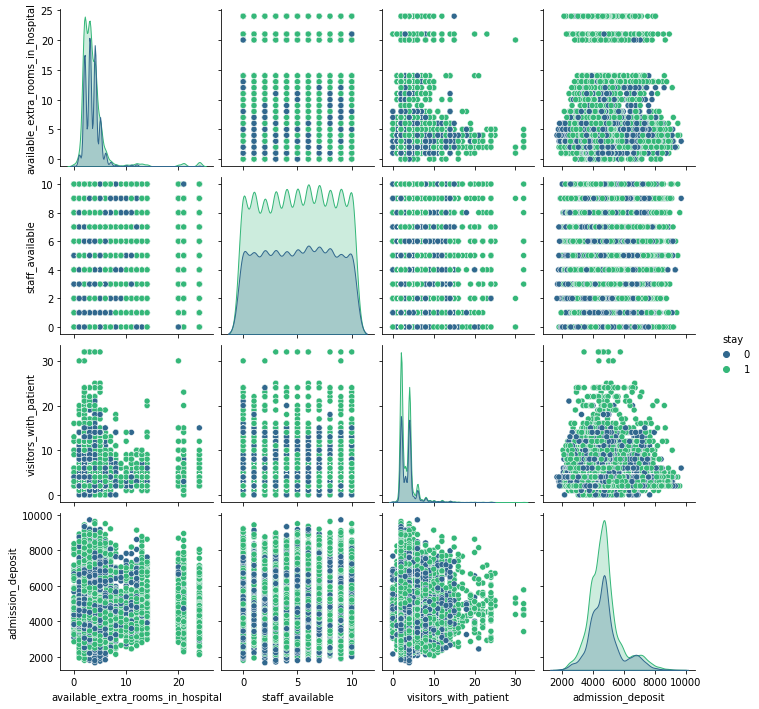

In [15]:
#Pairplot para variables cuantitativas. con un hue en stay y sample del 10% datos
sns.pairplot(df.drop(columns=['stay_days']).sample(frac=0.1), hue="stay", palette = 'viridis')
plt.show()

* **Se hace uso de `Boxplots` para analizar la distribución de las variables y la detección de outliers**. Se observa que solo la variable _staff_available_ no presenta valores atípicos
* Realizo un dataframe de outliers `df_outliers` para analizar que porcentaje representa en cada variable para luego analizar su remosión. Se observa que la variable que más presenta valores atípicos es _admission_deposit_ con un 8,3%

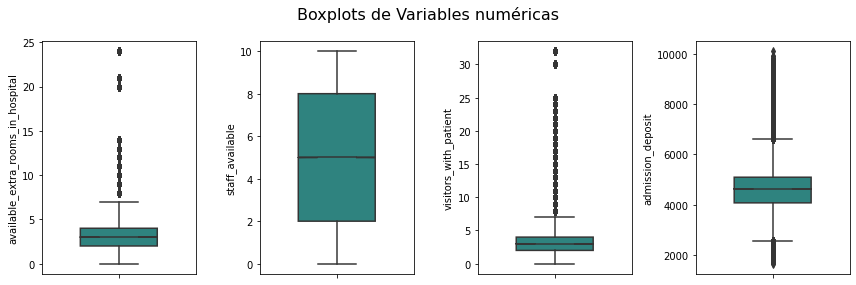

In [16]:
#Boxplots de variables numericas
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (12,4))
for i in range(0,4):
  sns.boxplot(data = df, y = num_cols[i], notch = True, showfliers = True, width = 0.5 ,  palette = 'viridis', ax = ax[i])
fig.suptitle('Boxplots de Variables numéricas', fontsize=16,fontweight=200)
plt.tight_layout()
plt.show()

In [17]:
#Calculo de outliers y porcentaje
outliers_dicc = {'Mediana': [], 'Q1': [], 'Q3':[], 'Limite Inferior': [], 'Limite Superior': [], 'Cantidad Outliers':[], '% Outliers':[] }
for i, col in enumerate(num_cols):
  M = df[col].median()
  Q1 = df[col].quantile(q=.25)
  Q3 = df[col].quantile(q=.75)
  IQR = Q3 - Q1
  LI = Q1 - 1.5*IQR
  LS = Q3 + 1.5*IQR
  outliers = df[(df[col]<LI) | (df[col]>LS)].shape[0]
  outliers_perc = outliers/df.shape[0]*100
  #Append de los valores en diccionario
  outliers_dicc['Mediana'].append(M)
  outliers_dicc['Q1'].append(Q1)
  outliers_dicc['Q3'].append(Q3)
  outliers_dicc['Limite Inferior'].append(LI)
  outliers_dicc['Limite Superior'].append(LS)
  outliers_dicc['Cantidad Outliers'].append(outliers)
  outliers_dicc['% Outliers'].append(outliers_perc)
df_outliers = pd.DataFrame(outliers_dicc, index=num_cols)

In [18]:
df_outliers

Mediana      Q1      Q3  Limite Inferior  \
available_extra_rooms_in_hospital     3.00    2.00    4.00            -1.00   
staff_available                       5.00    2.00    8.00            -7.00   
visitors_with_patient                 3.00    2.00    4.00            -1.00   
admission_deposit                  4627.49 4072.64 5092.35          2543.07   

                                   Limite Superior  Cantidad Outliers  \
available_extra_rooms_in_hospital             7.00              14603   
staff_available                              17.00                  0   
visitors_with_patient                         7.00              20163   
admission_deposit                          6621.92              34234   

                                   % Outliers  
available_extra_rooms_in_hospital        3.56  
staff_available                          0.00  
visitors_with_patient                    4.92  
admission_deposit                        8.35

#### Análisis variables cualitativas



* **Se utilizan `Barplots` graficados en forma múltiple para cada variable y separado por la variable _stay_**  
* Algunas observaciones interesantes son:
  * Las variables _age_ y _department_ podrian ser buenos clasificadores, ya que hay una separación marcada en cuando a la distribución de la variable target _stay_ dentro de las categorías de cada variable. Por ejemplo, rangos de edad de 11 a 50 años solo cuentan con estadías cortas, el resto de los rangos cuentan con hospitalización de larga duración

  * Hay categorías de variables que casi no tienen datos, por ejemplo surgery en _department_ o el rango etario de 91-100 años en _age_. Una vez aplicado el encoding en estas variables, su varianza debería tender a cero, por lo que no sería util para el modelo. **Se plantea luego aplicar VarianceThreshold de sklearn en un Pipeline para eliminar dichas variables como un paso extra**


In [19]:
# Matriz de 3x3 de variables categóricas para poder graficar
cat_cols_matrix = np.array(cat_cols).reshape(3,3)

In [20]:
#Ploteo de variables categóticas
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (15,10))
for i in range(0,3):
  for j in range(0,3):
    sns.countplot(data=df, x=cat_cols_matrix[i,j], hue="stay", ax=ax[i,j], palette = 'viridis')
    plt.setp(ax[i,j].get_xticklabels(), rotation=45, ha='center')
fig.suptitle('Barplots de Variables categóricas por estadía', fontsize=16,fontweight=200)
plt.tight_layout()
plt.show()

### **Observaciones y conclusiones EDA**
---
Se sacan algunas conclusiones generales y por variables

* **Valores faltantes y duplicados**: El dataset no cuenta con nulos ni duplicados 

* **Correlación entre variables**: El reporte de `PandasProfiling` entrega una sección de Correlación en base al tipo de variable (numérica, categórica o ambas) considerando algunos coeficientes como Pearson, CramerV, Spearman's, entre otras.  
De acuerdo a la correlación 'Auto' se ve que:
  - _stay_ está levemente correlacionada con las variables _department_, _age_, _gender_, _doctor_name_, _ward_facility_code_
  - A su vez, estas ultimas 4 features se encuentran correlacionadas entre sí por lo que se analiza en la sección de feature selection con cual quedarse

* **Variable target**: La variable dependiente a predecir por el modelo de clasificación es `stay`. No se trata de un dataset desbalanceado, ya que cuenta con un 60% y 40% de datos para las categorías de 1(larga) y 0 (corta)

* **Variables cuantitativas**: Cuenta con 4 variables numéricas (excluyendo la variable a predecir _stay_days_) con las siguientes características. Curtosis alta significa que los datos están concentrados cerca de la mediana, mientras que una curva de distribución con curtosis baja significa una curva mas aplanada con los datos mas distribuidos

Con respecto a los outliers, su ocurrencia no se debe a errores sino que son mas bien propios de cada registro por lo que no se deberían eliminar. En caso de considerar cierta variable se puede aplicar `RobustScaler` para el escalado

|              Variable             |       Distribución      |     Sesgo    | Curtosis | Outliers |
|:---------------------------------:|:-----------------------:|:------------:|:--------:|:--------:|
| available_extra_rooms_in_hospital |  Aproximadamente normal | A la derecha |   Alta   |    Si    |
| staff_available                   |         Uniforme        |       -      |  Pequeña |    No    |
| visitors_with_patient             |         Bimodal         | A la derecha |   Alta   |    Si    |
| admission_deposit                 | Aproximandamente normal | A la derecha |   Alta   |    Si    |

* **Variables categóricas**:

Cuenta con 9 variables categóricas sin incluir la variable a predecir _stay_.

Hay 3 variables ordinales, que al momento de aplicar el encoding se aplicará en el orden en que aparece en la columna Categorías (ya ordenado). El resto de las variables son nominales

Las categorías con pocos datos podrian significar categorías con varianza cercana a cero que puede afectar al modelo. Aunque se verá luego si se aplica un `VarianceThreshold`

|       Variable      | Tipo de variable categórica | Dicotómica o multicategórica | Cantidad de categorías |                                                     Categorías                                                    |    Categorías con pocos datos    |
|:-------------------:|:---------------------------:|:----------------------------:|:----------------------:|:-----------------------------------------------------------------------------------------------------------------:|:--------------------------------:|
| department          |           Nominal           |        Multicategórica       |            4           |                  'gynecology',   'radiotherapy',  'anesthesia',  'TB & Chest disease',  'surgery'                 | 'surgery',  'TB & Chest disease' |
| age                 |           Ordinal           |        Multicategórica       |           10           |         '0-10',  '11-20',  '21-30',  '31-40',  '41-50',  '51-60',  '61-70',  '71-80',  '81-90',  '91-100'         |    '0-10',  '91-100',  '81-90'   |
| gender              |           Nominal           |        Multicategórica       |            3           |                                            'Female',  'Male',  'Other'                                            |              'Other'             |
| severity_of_illness |           Ordinal           |        Multicategórica       |            3           |                                          'Minor',  'Moderate',  'Extreme'                                         |                 -                |
| ward_facility_code  |           Nominal           |        Multicategórica       |            6           |                                         'F',  'D',  'B',  'E',  'A',  'C'                                         |                 -                |
| health_conditions   |           Nominal           |        Multicategórica       |            6           |                'None',  'Other',  'High Blood Pressure',  'Diabetes',  'Asthama',  'Heart disease'                |                 -                |
| insurance           |           Nominal           |          Dicotómica          |            2           |                                                    'Yes',  'No'                                                   |                 -                |
| doctor_name         |           Nominal           |        Multicategórica       |            9           | 'Dr Olivia',  'Dr Sarah',  'Dr Nathan',  'Dr Sophia',  'Dr Sam',  'Dr Mark',  'Dr John',  'Dr Isaac',  'Dr Simon' |      'Dr Simon',  'Dr Isaac'     |
| type_of_admission   |           Ordinal           |        Multicategórica       |            3           |                                         'Trauma',  'Emergency',  'Urgent'                                         |                 -                |

## **2) Preparación de los datos**

### Feature Selection
---
Se toma como referencia [A Practical Guide to Dimensionality Reduction](https://storage.googleapis.com/kaggle-forum-message-attachments/469411/11253/dimreductiontechniquespydatadcoct2016-170626164019.pdf) de [PyData 2016](https://pydata.org/about/) (un programa educacional a nivel mundial de data) para realizar la selección de variables (Dimensionality Reduction)  
Los pasos y criterios seguidos son:
- Porcentaje de valores nulos: No hay variables con valores nulos, por lo que no se realizan reducción de campos de acuerdo a este criterio
- Variables con varianza cero: No hay variables con varianza nula o casi nula (mismos valores en todos los registros), por lo que no se dropean campos
- Correlación con el target y multicolinearidad
- Selección Tree-based Method (Feature importance)
- Criterio propio en base al problema

#### Correlación con el target y multicolinearidad
Utilizo los coeficientes de correlación para ver que features estarían asociadas con el target, y las features relacionadas entre sí.  
Las observaciones resultantes son idénticas a las del EDA:
  - _stay_ está levemente correlacionada con las variables _department_, _age_, _gender_, _doctor_name_, _ward_facility_code_ y a su vez estas features están correlacionadas entre sí
  - Para evitar redundancia de información (multicolinearidad) se elige la variable **_department_** por sobre _doctor_name_ y _ward_facility_code_. Las variables _age_ y _gender_, a pesar de que estén correlacionadas con department, son relativas al paciente y no al Centro de salud en si, por lo que también se considerarán para el análisis


* **Libreria `Dython` para analisis de correlacion de variables**  
Utilizo [Dython](https://github.com/shakedzy/dython) para hacer la correlación de variables tanto numericas como categóricas basado en los siguientes coeficientes:

     * `Pearson's R` para correlación de variables continua-continua
     * `Correlation Ratio` para correlación de variables categorica-continua
     * `Cramer's V` para correlación de variables categorica-categorica (basado en Chi-Cuadrado)


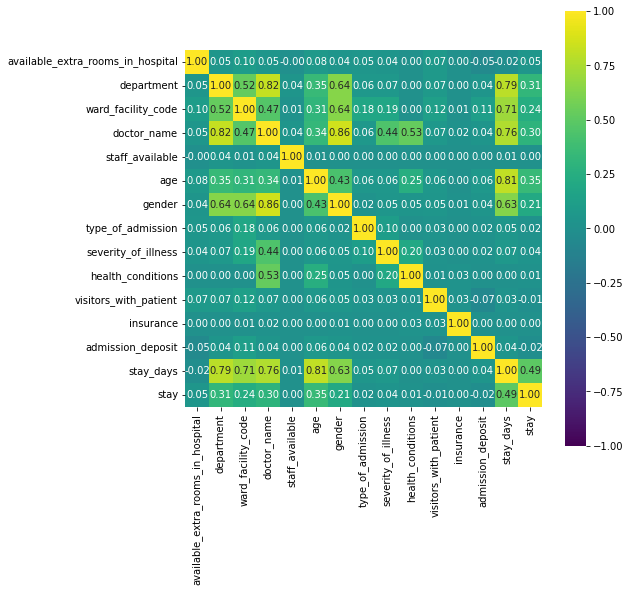

{'corr':                                    available_extra_rooms_in_hospital  \
 available_extra_rooms_in_hospital                               1.00   
 department                                                      0.05   
 ward_facility_code                                              0.10   
 doctor_name                                                     0.05   
 staff_available                                                -0.00   
 age                                                             0.08   
 gender                                                          0.04   
 type_of_admission                                               0.05   
 severity_of_illness                                             0.04   
 health_conditions                                               0.00   
 visitors_with_patient                                           0.07   
 insurance                                                       0.00   
 admission_deposit                         

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
associations(df, cmap="viridis",ax=ax)
#fig.savefig('Categorical Corr Heat Map. png')

#### Tree-based Methon (Feature importance)
Se utiliza RandomForest para obtener la importancia de las variables a la hora de realizar las predicciones.

**Observaciones**
  - Se obtiene df_importances luego de entrenar el modelo de RandomForest con variables codificadas. De acuerdo a las `feature_mportances_` del modelo las variables con preponderancia para la predicción y que se tendrán en cuenta son: _admission_deposit_ y_staff_available_

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
#División del Dataframe
X_num = df[num_cols]
X_cat = pd.get_dummies(df[cat_cols], columns = cat_cols, drop_first=True)
X = pd.concat([X_num,X_cat], axis=1)
y = df[['stay']]

In [24]:
X.head()

available_extra_rooms_in_hospital  staff_available  visitors_with_patient  \
0                                  4                0                      4   
1                                  4                2                      2   
2                                  2                8                      2   
3                                  4                7                      4   
4                                  2               10                      2   

   admission_deposit  gender_Male  gender_Other  severity_of_illness_Minor  \
0            2966.41            0             0                          0   
1            3554.84            0             0                          1   
2            5624.73            0             0                          0   
3            4814.15            0             0                          0   
4            5169.27            1             0                          0   

   severity_of_illness_Moderate  insurance_Yes  ward_facility_code_B  ...  \
0                             0              1                     0  ...   
1                             0              0                     1  ...   
2                             0              1                     1  ...   
3                             1              0                     0  ...   
4                             1              0                     0  ...   

   age_41-50  age_51-60  age_61-70  age_71-80  age_81-90  age_91-100  \
0          1          0          0          0          0           0   
1          0          0          0          0          0           0   
2          0          0          0          0          0           0   
3          0          0          0          0          0           0   
4          0          0          0          1          0           0   

   department_anesthesia  department_gynecology  department_radiotherapy  \
0                      0                      1                        0   
1                      0                      1                        0   
2                      0                      1                        0   
3                      0                      1                        0   
4                      1                      0                        0   

   department_surgery  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 42 columns]

In [25]:
#Feature importance
clf = RandomForestClassifier(n_estimators=50)
rf_feature_selection = clf.fit(X, y)
importances = rf_feature_selection.feature_importances_ 
df_feature_importances = pd.DataFrame(importances, index = X.columns, columns = ['Importancia']).sort_values('Importancia',ascending=False)

In [26]:
df_feature_importances

Importancia
admission_deposit                             0.39
staff_available                               0.11
available_extra_rooms_in_hospital             0.09
visitors_with_patient                         0.06
age_31-40                                     0.05
age_41-50                                     0.04
department_radiotherapy                       0.03
doctor_name_Dr Mark                           0.02
department_anesthesia                         0.02
department_gynecology                         0.02
age_61-70                                     0.02
age_21-30                                     0.01
age_51-60                                     0.01
age_71-80                                     0.01
type_of_admission_Trauma                      0.01
insurance_Yes                                 0.01
gender_Male                                   0.01
doctor_name_Dr Sam                            0.01
type_of_admission_Urgent                      0.01
severity_of_illness_Minor                     0.01
age_81-90                                     0.01
health_conditions_High Blood Pressure         0.00
severity_of_illness_Moderate                  0.00
doctor_name_Dr John                           0.00
ward_facility_code_B                          0.00
ward_facility_code_F                          0.00
ward_facility_code_D                          0.00
health_conditions_None                        0.00
health_conditions_Other                       0.00
ward_facility_code_E                          0.00
department_surgery                            0.00
doctor_name_Dr Sarah                          0.00
health_conditions_Diabetes                    0.00
doctor_name_Dr Nathan                         0.00
age_11-20                                     0.00
health_conditions_Heart disease               0.00
doctor_name_Dr Sophia                         0.00
doctor_name_Dr Olivia                         0.00
gender_Other                                  0.00
age_91-100                                    0.00
ward_facility_code_C                          0.00
doctor_name_Dr Simon                          0.00

#### Selección en base a criterio propio
De acuerdo al problema planteado considero a algunas variables importantes relativas al paciente que ingresa a ser hospitalizado y que se van a tomar en cuenta en el problema. Estas variables están relacionadas con la edad, el género y situación de salud del paciente (afecciones anteriores, tipo de admisión y seguro de salud)


### Variables Seleccionadas
---
Por los criterios mencionados en los puntos anteriores son: 
- **Cuantitativas:**  
  - _staff_available_
  - _admission_deposit_
- **Cualitativas Dicotómica:**
  - _insurance_
- **Cualitativas Multicategóricas Ordinales:**
  - _age_
  - _severity_of_ilness_
  - _type_of_admission_

- **Cualitativas Multicategóricas Nominales:**
  - _department_
  - _gender_
  - _health_conditions_

In [27]:
num_cols

['available_extra_rooms_in_hospital',
 'staff_available',
 'visitors_with_patient',
 'admission_deposit']

In [28]:
cat_cols

['gender',
 'severity_of_illness',
 'insurance',
 'ward_facility_code',
 'doctor_name',
 'health_conditions',
 'type_of_admission',
 'age',
 'department']

In [49]:
# Variables
num_features = ['staff_available']
dic_features = ['insurance']
ord_features = ['age','severity_of_illness','type_of_admission']
nom_features = ['department','gender','health_conditions']
total_features = num_features + dic_features + ord_features + nom_features

# Orden de Variables Ordinales para aplicar OrdinalEncoder: Es importante la posición en la que aparecen las variables
orden = [
    ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100'],
    ['Minor', 'Moderate', 'Extreme'],
    ['Trauma', 'Emergency', 'Urgent']
    ]

In [50]:
total_features

['staff_available',
 'insurance',
 'age',
 'severity_of_illness',
 'type_of_admission',
 'department',
 'gender',
 'health_conditions']

### División del Dataset en Train-Test Split
---

In [51]:
# Defino X e y
X = df[total_features]
y = df[['stay']]

In [52]:
X.head()

staff_available insurance    age severity_of_illness type_of_admission  \
0                0       Yes  41-50             Extreme            Trauma   
1                2        No  31-40               Minor            Trauma   
2                8       Yes  21-30             Extreme            Trauma   
3                7        No  31-40            Moderate            Urgent   
4               10        No  71-80            Moderate            Trauma   

   department  gender health_conditions  
0  gynecology  Female          Diabetes  
1  gynecology  Female     Heart disease  
2  gynecology  Female          Diabetes  
3  gynecology  Female              None  
4  anesthesia    Male          Diabetes

In [53]:
y.head()

stay
0     0
1     1
2     0
3     0
4     1

In [54]:
# Reparto de datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [55]:
# Verificación
print(f'X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}\ny_train shape: {X_train.shape}\ny_test shape: {X_test.shape}\n')

X_train shape: (328000, 8)
X_test shape: (82000, 8)
y_train shape: (328000, 8)
y_test shape: (82000, 8)



### Preprocesamiento de datos
---
Para facilitar el preprocesado de datos se utilizan pipelines por cada etapa

In [36]:
# Pipeline StandardScaler: para variables sin outliers
Pipe_StandardScaler = Pipeline(steps=[
                        ("Imputador mediana", SimpleImputer(strategy='median')),
                        ("StandardScaler", StandardScaler())
                        ])

In [37]:
# Pipeline RobustScaler: para variables con outliers
Pipe_RobustScaler = Pipeline(steps=[
                        ("Imputador mediana", SimpleImputer(strategy='median')),
                        ("StandardScaler", RobustScaler())
                        ])

In [38]:
# Pipeline OneHotEncoding
Pipe_OneHotEncoder = Pipeline(steps=[
                        #("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("OneHotEncoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
                        ])

In [39]:
# Pipeline OrdinalEncoder
Pipe_OrdinalEncoder = Pipeline(steps=[
                        ("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("OrdinalEncoder", OrdinalEncoder(categories=orden))
                        ])

In [40]:
# Debido a que LabelBinarizer no acepta mas de dos argumentos por lo que se hace una modificación
class LabelBinarizerPipeline(LabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipeline, self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipeline, self).transform(X)

    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipeline, self).fit(X).transform(X)

In [41]:
# Pipeline LabelBinarizer
Pipe_LabelBinarizer = Pipeline(steps=[
                        ("Imputador moda", SimpleImputer(strategy='most_frequent')),
                        ("LabelBinarizer", LabelBinarizerPipeline())
                        ])

In [56]:
# Preprocesador de columnas
Preprocesador = ColumnTransformer( 
                        transformers = [
                            ('Escalado Estandar', Pipe_StandardScaler, ['staff_available']),
                            #('Escalado Robusto',Pipe_RobustScaler,['admission_deposit']),
                            ('Encoding Label', Pipe_LabelBinarizer, dic_features),
                            ('Encoding Ordinal', Pipe_OrdinalEncoder, ord_features),
                            ('Encoding OneHot', Pipe_OneHotEncoder, nom_features)
                            ],
                        remainder='drop', n_jobs=-1)

In [57]:
# Preprocesado de Features en train y test
X_train_procesado = Preprocesador.fit_transform(X_train)
X_test_procesado = Preprocesador.transform(X_test)

* Armado del Dataframe con sus respectivas columnas para corroborar el preprocesado

In [58]:
# Obtención de las columnas
encoded_cat = Preprocesador.named_transformers_['Encoding OneHot'].named_steps['OneHotEncoder'].get_feature_names_out()
labels = np.concatenate([num_features,dic_features,ord_features, encoded_cat])

In [59]:
labels

array(['staff_available', 'insurance', 'age', 'severity_of_illness',
       'type_of_admission', 'department_anesthesia',
       'department_gynecology', 'department_radiotherapy',
       'department_surgery', 'gender_Male', 'gender_Other',
       'health_conditions_Diabetes', 'health_conditions_Heart disease',
       'health_conditions_High Blood Pressure', 'health_conditions_None',
       'health_conditions_Other'], dtype=object)

In [88]:
# Dataframe transformado
df_X_train_procesado = pd.DataFrame(X_train_procesado, columns=labels, index = X_train.index)
df_X_train_procesado.head(10)

staff_available  insurance  age  severity_of_illness  \
113232            -0.32       1.00 3.00                 1.00   
329178            -0.64       1.00 6.00                 1.00   
248342             0.63       1.00 6.00                 2.00   
209872            -0.01       1.00 3.00                 1.00   
194305            -1.59       1.00 1.00                 0.00   
87560              0.94       1.00 6.00                 1.00   
339324            -0.64       0.00 6.00                 2.00   
41030              1.58       1.00 2.00                 2.00   
254337            -1.59       1.00 7.00                 1.00   
197941             1.58       1.00 3.00                 1.00   

        type_of_admission  department_anesthesia  department_gynecology  \
113232               0.00                   0.00                   1.00   
329178               0.00                   0.00                   0.00   
248342               0.00                   1.00                   0.00   
209872               0.00                   0.00                   1.00   
194305               0.00                   0.00                   1.00   
87560                0.00                   1.00                   0.00   
339324               0.00                   0.00                   0.00   
41030                1.00                   0.00                   0.00   
254337               0.00                   0.00                   0.00   
197941               0.00                   0.00                   1.00   

        department_radiotherapy  department_surgery  gender_Male  \
113232                     0.00                0.00         0.00   
329178                     0.00                0.00         1.00   
248342                     0.00                0.00         0.00   
209872                     0.00                0.00         0.00   
194305                     0.00                0.00         0.00   
87560                      0.00                0.00         0.00   
339324                     1.00                0.00         1.00   
41030                      1.00                0.00         1.00   
254337                     1.00                0.00         1.00   
197941                     0.00                0.00         0.00   

        gender_Other  health_conditions_Diabetes  \
113232          0.00                        0.00   
329178          0.00                        0.00   
248342          1.00                        1.00   
209872          0.00                        0.00   
194305          0.00                        0.00   
87560           1.00                        0.00   
339324          0.00                        1.00   
41030           0.00                        0.00   
254337          0.00                        0.00   
197941          0.00                        0.00   

        health_conditions_Heart disease  \
113232                             0.00   
329178                             0.00   
248342                             0.00   
209872                             0.00   
194305                             0.00   
87560                              0.00   
339324                             0.00   
41030                              0.00   
254337                             0.00   
197941                             0.00   

        health_conditions_High Blood Pressure  health_conditions_None  \
113232                                   0.00                    1.00   
329178                                   0.00                    0.00   
248342                                   0.00                    0.00   
209872                                   0.00                    1.00   
194305                                   1.00                    0.00   
87560                                    0.00                    0.00   
339324                                   0.00                    0.00   
41030                                    0.00                    1.00   
254337                  

In [61]:
X_train.head(10)

staff_available insurance    age severity_of_illness  \
113232                4       Yes  31-40            Moderate   
329178                3       Yes  61-70            Moderate   
248342                7       Yes  61-70             Extreme   
209872                5       Yes  31-40            Moderate   
194305                0       Yes  11-20               Minor   
87560                 8       Yes  61-70            Moderate   
339324                3        No  61-70             Extreme   
41030                10       Yes  21-30             Extreme   
254337                0       Yes  71-80            Moderate   
197941               10       Yes  31-40            Moderate   

       type_of_admission          department  gender    health_conditions  
113232            Trauma          gynecology  Female                 None  
329178            Trauma  TB & Chest disease    Male                Other  
248342            Trauma          anesthesia   Other             Diabetes  
209872            Trauma          gynecology  Female                 None  
194305            Trauma          gynecology  Female  High Blood Pressure  
87560             Trauma          anesthesia   Other              Asthama  
339324            Trauma        radiotherapy    Male             Diabetes  
41030          Emergency        radiotherapy    Male                 None  
254337            Trauma        radiotherapy    Male  High Blood Pressure  
197941            Trauma          gynecology  Female                Other

In [76]:
X_train_procesado.shape

(328000, 16)

In [63]:
X_test_procesado.shape

(82000, 16)

In [64]:
y_train.shape

(328000, 1)

In [65]:
y_test.shape

(82000, 1)

#### Imputación de valores faltantes

#### Escalado de Variables numéricas

Encoder Variables categóricas 

## 3) Modelado 

In [89]:
#Objeto de Modelos de clasificación:
#Se defina como un objeto (o diccionario) donde el key es el nombre de cada modelo y el valor la función correspondiente a dicho modelo
dict_classifiers = {
    "Tree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
    "LogisticReg": LogisticRegression(),
    "SVM": LinearSVC(),
    "RandomForest": RandomForestClassifier()
}

In [92]:
# Se define una función para obtener un resumen de los datos de entrenamiento y testeo
no_classifiers = len(dict_classifiers.keys())

def batch_classify(X_train, y_train, X_test, y_test):
    columnas = ['Modelo', 'Training Time', 'Accuracy (Train)', 'Accuracy (Test)', 'Recall','CrossVal Score']
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,len(columnas))), columns = columnas)
    count = 0
    for key, classifier in dict_classifiers.items():
        #print(key,classifier)
        #Entrenamiento
        t_start = perf_counter()
        classifier.fit(X_train, y_train)
        t_end = perf_counter()
        t_diff = t_end - t_start
        acc_train = classifier.score(X_train, y_train)
        #Predicción
        y_test_pred = classifier.predict(X_test)#.reshape(-1,1)
        acc_test =accuracy_score(y_test, y_test_pred)
        #Recall
        recall = recall_score(y_test, y_test_pred, pos_label = 1, average= 'binary')
        #Validación cruzada
        cv_scores = cross_val_score(classifier, X_train, y_train, cv=4)
        cv_mean = cv_scores.mean()
        #print(classifier, t_diff,acc_train,acc_test,recall,cv_mean)
        #Tabla resultante
        print(f'Tiempo de entrenamiento para {key}: {round(t_diff,2)} seg\n')
        df_results.loc[count,'Modelo'] = key
        df_results.loc[count,'Training Time'] = t_diff
        df_results.loc[count,'Accuracy (Train)'] = acc_train
        df_results.loc[count,'Accuracy (Test)'] = acc_test
        df_results.loc[count,'Recall'] = recall
        df_results.loc[count,'CrossVal Score'] = cv_mean
        count+=1
    return df_results

In [93]:
#Aplicación y evaluación de los modelos de clasificación
df_results = batch_classify(X_train_procesado, y_train, X_test_procesado, y_test)

Tiempo de entrenamiento para Tree: 8.07 seg



AttributeError: 'NoneType' object has no attribute 'split'

In [ ]:
df_results

Modelo  Training Time  Accuracy (Train)  Accuracy (Test)  Recall  \
0          Tree           0.00              1.00             0.70    0.76   
1           KNN           0.00              0.81             0.70    0.77   
2   LogisticReg           0.00              0.60             0.59    0.83   
3           SVM           0.00              0.60             0.59    0.85   
4  RandomForest           0.00              1.00             0.70    0.76   

   CrossVal Score  Trainig Time  
0            0.70          4.27  
1            0.70          0.03  
2            0.59          7.21  
3            0.59         96.99  
4            0.70         63.37